# <center> Variational Quantum Eigensolver (VQE) for Diatomic Molecules </center>
## <center> Case study: Molecular Hydrogen $H_2$ </center>

In this tutorial we introduce the Variational Quantum Eigensolver (VQE) by providing the necessary background and demonstrating its implementation to find the ground state energy for Hydrogen molecule.  

**Let's describe the problem:**   
Finding ground state energy of many-body interacting fermionic $k$-local Hamiltonians (i.e. the terms of Hamiltonian act on at most $k$ particles) is equivalent to solving the eigenvalue problem for ground state energy:    
$$H\lvert \Phi \rangle = E_{ground}\lvert \Phi \rangle  \hspace{1cm}(1)$$  

For $k \geq 2$ the problem in the full generality is QMA-complete ([SIAM J. Comput. 35, 1070 (2006)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.95.3391&rep=rep1&type=pdf)). QMA stands for [Quantum Merlin-Arthur](https://en.wikipedia.org/wiki/QMA), the quantum analog of the nonprobabilistic complexity class NP or the probabilistic complexity class MA. It is related to BQP (bounded-error quantum, probabilistic) in the same way NP is related to P, or MA is related to BPP.  

We will solve the eigenvalue problem for the Hydrogen molecule $H_2$ using the VQE algorithm. The choice of this algorithm is made because it requires less qubit coherence time, a bottleneck for current quantum computers harware. We have [previously solved the same problem](https://github.com/gate42qc/pea_hydrogen-molecule) using another algorithm called Quantum Phase Estimation. QPE is not hardware efficient as one of the steps in the algorithm requires Trotterization in the exponentiation of the Hamiltonian, thus making the gate sequence to arrive to a solution prohibitively long for current lifetimes of qubits.  


## <center> VQE </center>
VQE uses Ritz’s variational principle to prepare **_approximations_** to the ground state and compute its energy. The advantage of VQE over classical simulation methods is that is can prepare trial states that are not amenable to efficient classical numerics.   
  
Let's describe how it works step-by-step. 

1. The quantum computer is used to prepare variational trial states that depend on a set of parameters  (image taken from [arXiv:1704.05018](https://arxiv.org/pdf/1704.05018.pdf)).  <img src="images/vqe_circuit.png">
 In the image the 6 horizontal lines represent the qubits. The circuit is composed of a sequence of interleaved single-qubit rotations, and entangling unitary operations $U_{ENT}$ that entangle all the qubits in the circuit. A final set of post-rotations prior to qubit readout are used to measure the expectation values of the terms in the qubit Hamiltonian (see next step), and estimate the energy of the trial state.

2. The expectation value of the energy (the cost function) is estimated and used by a classical optimizer to generate a new set of improved parameters. 
    * For the energy expectation sampling procedure, firstly it is convenient to expand the Hamiltonian in the Pauli basis  $$H = \sum_{i=1}^T \alpha_i P_i  \hspace{1cm} (2)$$
    where $P_i \in \{I, \sigma_x, \sigma_y, \sigma_z\}^{\otimes N}$ is a tensor product of single-qubit Pauli operators on $N$ qubits.
    * The energy can be obtained averaging the Hamiltonian in the quantum state prepared by our circuit in the step 1 $$\langle H \rangle = \sum_{i=1}^T \alpha_i \langle P_i\rangle \hspace{1cm}  (3)$$
    * Each Pauli term then **can be sampled from the circuit** in step 1 by doing appropriate qubit post-rotations beforhand (the last vertical gate array in the image above).  
    

Overall, the algorithm pseudocode looks as follows:

```code
Algorithm: Hardware-efficient optimization of quantum Hamiltonian problems  
1: Map the quantum Hamiltonian problem to a qubit Hamiltonian H  
2: Choose a depth d for the quantum circuit that prepares the trial state  
3: Choose a set of variational controls θ_1 that parametrize the starting trial state  
4: Choose a number of samples S for the feedback loop and one Sf for the final estimation  
5: Choose a number of maximal control updates kL  
6: while Ef has not converged do  
7:     procedure Quantum Feedback Loop  
8:         for k = 1 to kL do  
9:             Prepare trial states around θ_k and evaluate <H> with S samples  
10:            Update and store the controls θ_k  
11:        end for  
12:        Evaluate Ef = <H> using the best controls with Sf samples  
13:    end procedure  
14:    Increase d, kL, S, Sf  
15: end while  
16: return Ef  
```  

Note, that VQE is a very flexible algorithm - there are many variants and modifications. Don't feel confused if you see a VQE which is different from the particular implementation we use here - the general idea behind the algorithm is the same.

## <center> Step by step:</center> 
### <center>1. Mapping the Hamiltonian to qubit Hamiltonian </center>
For this tutorial, we will estimate the **Hydrogen molecule**'s ground state energy. For that end, we start using the [OpenFermion](https://github.com/quantumlib/OpenFermion) package to construct the Hydrogen molecule. To reproduce the code in this tutorial, please make sure to install all the required packages.  

First let's make the necessary imports:

In [1]:
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from openfermionpyscf import run_pyscf

Let's create function that accepts diatomic molecule's name and interatomic bond distance as arguments and returns a data structure (`PauliSum`), a representation of the molecule's information, acceptable for Rigetti's quantum computer or simulator. One can also repeat this for other platforms, e.g. IBM-Q.

In [2]:
def get_diatomic_hamiltonian(atom_1, atom_2, bond_dist):
    """
    creates a diatomic hamiltonian using openfermion library
    :param bond_dist: float, the geometrical distance between Hydrogen atoms
    :param name: string, name of the molecule, e.g. 'H' for Hydrogen molecule
    returns a pyquil PauliTerm object
    """
    #-------------------------------------------------------#
    # constructing Hamiltonian in the second quantized form
    #-------------------------------------------------------#
    geometry = [[atom_1, [0, 0, 0]], [atom_2, [0, 0, bond_dist]]] # H--H min energy distance = 0.74pm
    basis = 'sto-3g'
    multiplicity = 1 #(2S+1)
    charge = 0
    molecule = MolecularData(geometry, basis, multiplicity, charge)
    # this calculates necessary integrals for coefficients in 2nd quantized form
    molecule = run_pyscf(molecule) 
    
    #-------------------------------------------------------#
    # constructing Hamiltonian in the qubit representation
    #-------------------------------------------------------#
    qubit_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
    pyquil_qubit_hamiltonian = qubitop_to_pyquilpauli(qubit_hamiltonian)
    #-------------------------------------------------------#
    
    return pyquil_qubit_hamiltonian

Let's look at the created qubit representation of the Hamiltonian of Hydrogen molecule at bond sidtance of 0.74pm. We do it by printing the output of the above function:

In [3]:
print(type(get_diatomic_hamiltonian('H', 'H', 0.74)), '\n')
print(get_diatomic_hamiltonian('H', 'H', 0.74))

<class 'pyquil.paulis.PauliSum'> 

(-0.09706626816762878+0j)*I + (0.1714128264477689+0j)*Z0 + (0.17141282644776892+0j)*Z1 + (-0.22343153690813564+0j)*Z2 + (-0.22343153690813558+0j)*Z3 + (0.16868898170361207+0j)*Z0*Z1 + (0.045302615503799264+0j)*Y0*X1*X2*Y3 + (-0.045302615503799264+0j)*Y0*Y1*X2*X3 + (-0.045302615503799264+0j)*X0*X1*Y2*Y3 + (0.045302615503799264+0j)*X0*Y1*Y2*X3 + (0.12062523483390414+0j)*Z0*Z2 + (0.1659278503377034+0j)*Z0*Z3 + (0.1659278503377034+0j)*Z1*Z2 + (0.12062523483390414+0j)*Z1*Z3 + (0.1744128761226159+0j)*Z2*Z3


We have just represented the Hamiltonian in the form of Eq (2). A term such as $X0*X1*Y2*Y3$ is a 4-qubit Pauli operator, an operator from $\mathcal{(C^2)}^{\otimes 4}$. The asteriscs should be understood as tensor products $\otimes$. Whereas a term with one operator, say, $Z0$, should be understood as $Z0*I1*I2*I3$, where $Ik$ stand for the identity operator acting on the qubit $k$.  
Later we will sample the expected value of such operators, sum them up with the respective coefficients in the above Hamiltonian, hence estimate the mean energy. To make sure we have the ground state energy, we have to construct the ground state by implementing the circuit in the picture above. Let's do it.

### <center> 2. Implementing the state preparation circuit </center>

Now that we know that the Hamiltonian is an operator from Hilbert space $\mathcal{H^{\otimes 4}}$, below we define 4 qubits to start with

In [4]:
number_of_qubits = 4
qubits = [0, 1, 2, 3]

Let's now create the necessary pieces to construct the circuit. For details, see the description of the `get_ansatz_circuit_genrator` (and other pieces of code it uses) in the module `random_circuit` in the same directory as this jupyter notebook.

In [5]:
import numpy as np
import random
from pyquil.quil import Program
import pyquil.api as api
from pyquil.gates import *
# we also import a function from module random_circuit we created
from random_circuit import get_ansatz_circuit_genrator

In [6]:
#print(type(variational_state_evolve(thetas)))  # <class 'pyquil.quil.Program'>
d = 1 # the loop depth
# this function passed into vqe_run as argument
variational_state_evolve = get_ansatz_circuit_genrator(qubits, d)

### <center> 3. Choosing a set of variational controls $\vec{θ}$ that parametrize the trial state </center>

In [7]:
thetas = np.random.rand(number_of_qubits + number_of_qubits*d)*np.pi

In [8]:
# initialize thetas 
#thetas = np.random.rand(4*number_of_qubits*d)*2*np.pi

print(thetas, '\n\n', variational_state_evolve(thetas))

[0.76724374 0.11082671 1.11522745 2.11362116 0.80470003 1.56978225
 2.43672545 2.58247125] 

 PRAGMA PRESERVE_BLOCK
RX(0.7672437435488132) 0
RY(0.11082671354758757) 1
RX(2.113621164437387) 2
RZ(1.1152274495177141) 3
PRAGMA END_PRESERVE_BLOCK
PRAGMA PRESERVE_BLOCK
CZ 0 1
CZ 1 2
CZ 2 3
RX(0.8047000340780152) 0
RY(1.5697822491506077) 1
RX(2.5824712506560714) 2
RZ(2.436725445449691) 3
PRAGMA END_PRESERVE_BLOCK



### <center> Steps 4-16 are implemented in Rigetti's algorithms library [Grove, VQE](https://github.com/rigetti/grove/blob/master/grove/pyvqe/vqe.py) </center>  

In orther to use the vqe instance from Grove, we need some imports.
The imports include the `minimize` function from `scipy.optimize`. This function will take care of finding the best parameters of our quantum circuit to sample energy expectations.
(make sure you have installed pyquil and started `quilc -S` and `qvm -S` in 2 different terminals)

In [9]:
from pyquil.api import get_qc
qc = get_qc("4q-qvm")

# can call the below options
# qc = WavefunctionSimulator ## to debug algorithm
# qc = get_qc("5q-qvm") ## to debug sampling
# qc = get_qc("9q-square-qvm") ## to debug mapping to a lattice
# qc = get_qc("9q-square-noisy-qvm") ## to debug generic noise characteristics
# qc = get_qc("Aspen-0-16Q-A-qvm") ## to debug mapping to a real lattice
# qc = get_qc("Aspen-0-16Q-A-noisy-qvm") ## to debug noise characteristics of a real device
# qc = get_qc("Aspen-0-16Q-A") ## to run on a real device

In [10]:
#from grove.pyvqe.vqe import VQE
from vqe import VQE
from scipy.optimize import minimize

The VQE object has a method `vqe_run` that takes all the arguments in the algorithm and takes care of the minimization routine. The arguments are, specifically,
- **variational_state_evolve**: function that takes a set of parameters and returns a pyQuil program.
- **hamiltonian**: (PauliSum) object representing the hamiltonian of which to take the expectation value.
- **initial_params**: (ndarray) vector of initial parameters for the optimization
- **gate_noise**: list of Px, Py, Pz probabilities of gate being applied to every gate after each get application
- **measurement_noise**: list of Px', Py', Pz' probabilities of a X, Y or Z being applied before a measurement.
- **jacobian**: (optional) method of generating jacobian for parameters (Default=None).
- _**qc**: (optional) QuantumComputer object._ (not supported yet, [see the issue in github](https://github.com/rigetti/grove/issues/184)), instead use **qvm** wavefunction simulator
- **disp**: (optional, use print, default None) display level. If True then each iteration expectation and parameters are printed at each optimization iteration.
- **samples**: (int) Number of samples for calculating the expectation value of the operators.  If `None` then faster method, dotting the wave function with the operator, is used. Default=None.
- **return_all**: (optional, bool) request to return all intermediate parameters determined during the optimization.


Let's prepare the arguments beforehand.

In [11]:
bond_dists = np.arange(0.3, 2.3, 0.07)
# get Hamiltonians for each interatomic distance
hamiltonians = [get_diatomic_hamiltonian('H', 'H', bond_dist) for bond_dist in bond_dists]
initial_parameters = thetas
len(bond_dists)

29

In [12]:
import time
inst = VQE(minimizer=minimize, minimizer_kwargs={'method': 'COBYLA'}) # 'BFGS'

Now we are ready to run the VQE for our state preparation circuit and compute the mean energy for the specified Hydrogen molecule Hamiltonian. Running the below code will take some time (the `time` module counts it)

Below, the expectation value of Hamiltonian $H$ on ansatz state is directly calculated through matrix multiplication $\langle \psi_{ansatz} \lvert H \rvert \psi_{ansatz}\rangle$. This is done when we don't specify samples: `samples=None`

In [13]:
start = time.time()
print("-------------------starting optimization---------------------")

# # the VQE result at each interatomic distance is stored results_wf_sim
results_wf_sim = [inst.vqe_run(variational_state_evolve, hamiltonian, initial_params=initial_parameters, 
            gate_noise=None, measurement_noise=None,
            jacobian=None, qc=qc, disp=None, 
            samples=None, return_all=False) for hamiltonian in hamiltonians]


end = time.time()
print("------------optimization done - elapsed time is:--------------")
print((end - start)/60, 'minutes')

-------------------starting optimization---------------------
------------optimization done. elapsed time is:--------------
2.318471972147624 minutes


Now let's see the optimized circuit parameters for each Hamiltonian corresponding to different interatomic distances specified in `bond_dists` for $H_2$ molecule. Below is the output of `vqe_run` method, a list of dictionaries, in which the value for key `'x'` represents the learned parameters for state preparation circuit, and the value for key `'fun'` represents the corresponding the scalar value of the objective function, the energy expectation in our case.

In [14]:
#results_wf_sim

In [15]:
# wavefunction simulation results
energies_wf_sim = [res.fun for res in results_wf_sim]
best_thetas_wf_sim = [res.x for res in results_wf_sim]

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

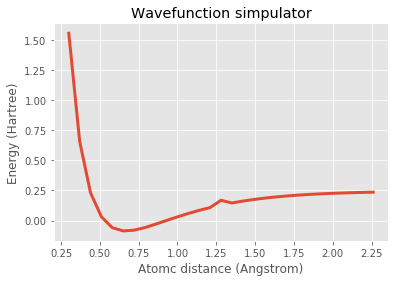

In [42]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15)))
plt.plot(bond_dists, energies_wf_sim, lw=3)
plt.title('Wavefunction simpulator')
plt.xlabel('Atomc distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.savefig('images/H2_energy.png', format='png', dpi=1000)
plt.show()

The above VQE instance when no samples provided is implemented such a way to make function minimization faster and will not work if one modelled gate and measurement noise cases. 

### Estimating energy expectation via sampling
If you still want to try with samples (and no noise), it may take some time. Why?  
* It makes optimization of `number_of_qubits + number_of_qubits*d` parameters for ansatz state preparation circuit `variational_state_evolve` 
* for the cost function being the Hamiltonian Eq(3) 
* which contains 15 terms (each being a 16 dimentional operator in Hilbert space, PauliTerm object) for $H_2$, 
* for each term evaluates expectation from number of samples you provide (and sums them up)
* all above done for `len(bond_dists)` different bond distances

## <center> Running with noise </center>

Running VQE for noisy simulator requires to run with samples option provided. When runnig VQE on real hardware the noisy simulation should capture the imperfections of NISQ hardware.  
Prepare corresponding parameters to feed to `vqe_run` with `samples=` some number you choose and noise options. Please apply either gate or measurement noise.

In [18]:
pauli_channel = [0.1, 0.1, 0.1] #10% chance of each gate at each timestep
noisy_qc = get_qc("4q-qvm", noisy=True) # api.QVMConnection(gate_noise=pauli_channel)
meas_channel = [0.1, 0.1, 0.1] #10% chance of each gate at each measurement
noisy_meas_qvm = api.QVMConnection(measurement_noise=meas_channel)

In [19]:
inst_noise = VQE(minimizer=minimize, minimizer_kwargs={'method': 'COBYLA'}) # 'BFGS'

Running the below code will take long time (hours).

In [20]:
# Returns the optimal parameters and minimum expecation
start = time.time()
print("-------------------starting optimization---------------------")

# the VQE result at each interatomic distance is stored results_sampl
results_sampl = [inst_noise.vqe_run(variational_state_evolve, ham, initial_params=initial_parameters, 
                                    gate_noise=pauli_channel, measurement_noise=None,
                                    jacobian=None, qc=noisy_qc, disp=None, 
                                    samples=10, return_all=False) 
                 for ham in hamiltonians]


end = time.time()
print("-------------------optimization done. elapsed time is:---------------------")
print((end - start)/60, 'minutes')

-------------------starting optimization---------------------


/home/hakob/anaconda3/lib/python3.6/site-packages/pyquil/paulis.py:120: FutureWarning: `PauliTerm.id()` will not work on PauliTerms where the qubits are not sortable and should be avoided in favor of `operations_as_set`.
  FutureWarning)


-------------------optimization done. elapsed time is:---------------------
171.4574207663536 minutes


In [21]:
# sampling results
energies_sampl = [res.fun for res in results_sampl]
best_thetas_sampl = [res.x for res in results_sampl]

Now with the newly learnt parameters, we sample for the final estimation ($S_f=1000$ samples, see step 4 in the pseudocode in the beginning of the notebook). The below code does it for different Hamiltonians corresponding to different bond distances.

In [34]:
# create dictionary and store, for each Hamiltonian, the expectation values 
# corresponding to different circuit parameters
start = time.time()

#expectations_th = [inst_noise.expectation(variational_state_evolve(b_thetas), ham, 1000, qc) 
#                   for b_thetas, ham in zip(best_thetas_sampl, hamiltonians)]
expectations_th = [inst_noise.expectation(variational_state_evolve(best_thetas_sampl[5]), ham, 1000, qc) 
                   for ham in hamiltonians]

end = time.time()
print('elapsed time is', (end - start)/60, 'minutes')

/home/hakob/anaconda3/lib/python3.6/site-packages/pyquil/paulis.py:120: FutureWarning: `PauliTerm.id()` will not work on PauliTerms where the qubits are not sortable and should be avoided in favor of `operations_as_set`.
  FutureWarning)


elapsed time is 2.182724690437317 minutes


In [43]:
# `expectations_th` is a list of energy expectations (29 of them) for each 29 Hamiltonians 
# we seperate and take mean 
mean_exps = [np.mean(expectations_th[i:i+29]) for i in range(29)]
#mean_exps

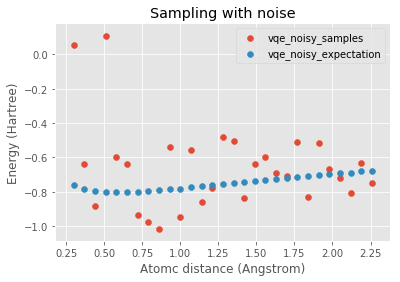

In [44]:
plt.scatter(bond_dists, energies_sampl, label='vqe_noisy_samples')
plt.scatter(bond_dists, mean_exps, label='vqe_noisy_expectation')
plt.title('Sampling with noise')
plt.xlabel('Atomc distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend(loc='upper right')
plt.savefig('images/H2_energy_sam.png', format='png', dpi=1000)
plt.show()

#### TODO: Reduce noise by error mitigation technique